# Предсказание цены криптовалюты Arbitrum (ARB)

<center> <img src=https://s2.tokeninsight.com/static/news/cover/img/cover_(49).jpg  width=500px, height=350> </center>



# Нам дан временной ряд цены на криптовалюту (альткоин)  ARB. Нужжно предсказать поведение цены 
# Что такое Arbitrum (ARB)?
Arbitrum - это решение для масштабирования Ethereum второго уровня (L2). Он использует  оптимистичные роллапы (optimistic rollups) для  повышения скорости, масштабируемости и экономичности Ethereum. При этом преимущество Arbitrum - в безопасности и совместимости Ethereum. Ещё одно преимущество - более высокая пропускная способность и более низкие комиссии по сравнению с Ethereum. Это стало возможным благодаря перемещению большей части нагрузки по вычислениям и хранению данных за пределы блокчейна.

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import floor,ceil,sqrt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

In [2]:
df = pd.read_csv('data/ARB_All_graph_coinmarketcap_update.csv', sep=';', parse_dates=['timestamp'], index_col=['timestamp'], dayfirst=True)
df.head()

,name,open,high,low,close,volume,marketCap
timestamp,,,,,,,
2023-03-24 00:00:00+00:00,2781,1.325396,1.555872,1.186060,1.272492,2.537710e+09,1.622427e+09
2023-03-25 00:00:00+00:00,2781,1.272393,1.307232,1.192970,1.224705,1.294894e+09,1.561498e+09
2023-03-26 00:00:00+00:00,2781,1.224117,1.341853,1.208092,1.283315,1.059588e+09,1.636227e+09
2023-03-27 00:00:00+00:00,2781,1.282521,1.320275,1.124495,1.162705,1.014241e+09,1.482449e+09
2023-03-28 00:00:00+00:00,2781,1.162855,1.220483,1.120494,1.217757,6.966363e+08,1.552640e+09


In [3]:
df.shape

(323, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 323 entries, 2023-03-24 00:00:00+00:00 to 2024-02-09 00:00:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       323 non-null    int64  
 1   open       323 non-null    float64
 2   high       323 non-null    float64
 3   low        323 non-null    float64
 4   close      323 non-null    float64
 5   volume     323 non-null    float64
 6   marketCap  323 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 20.2 KB


#### Создадим графики для визуализации изменения цен, объема торгов и капитализации рынка со временем.

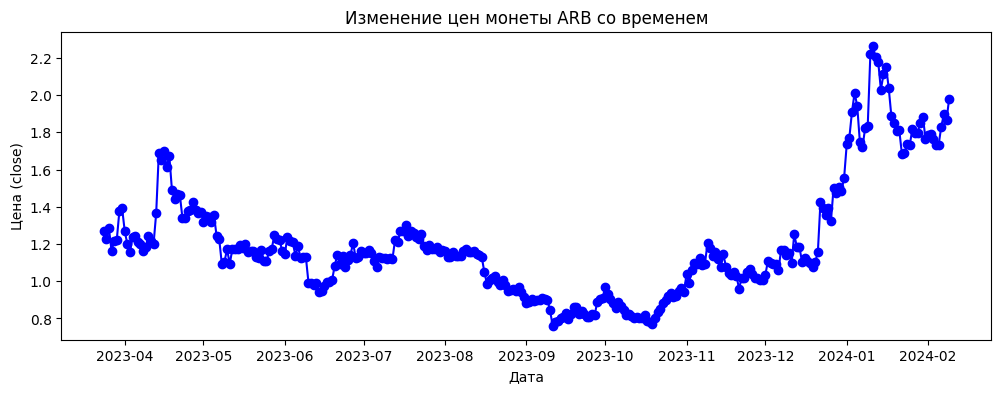

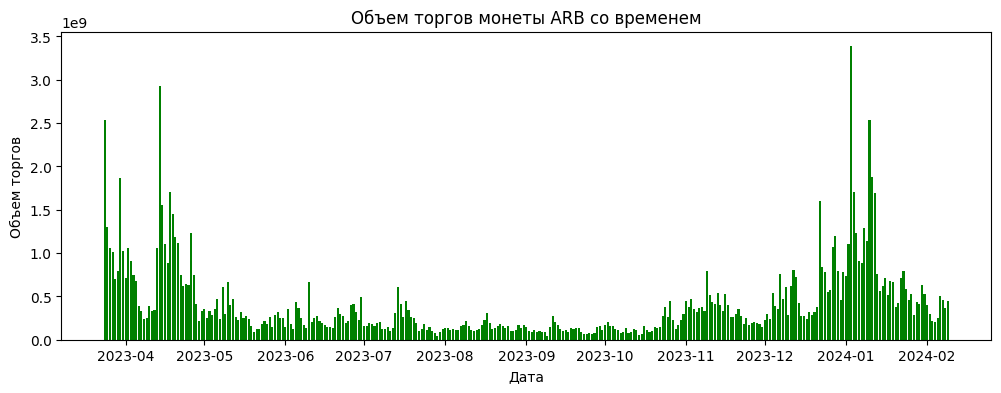

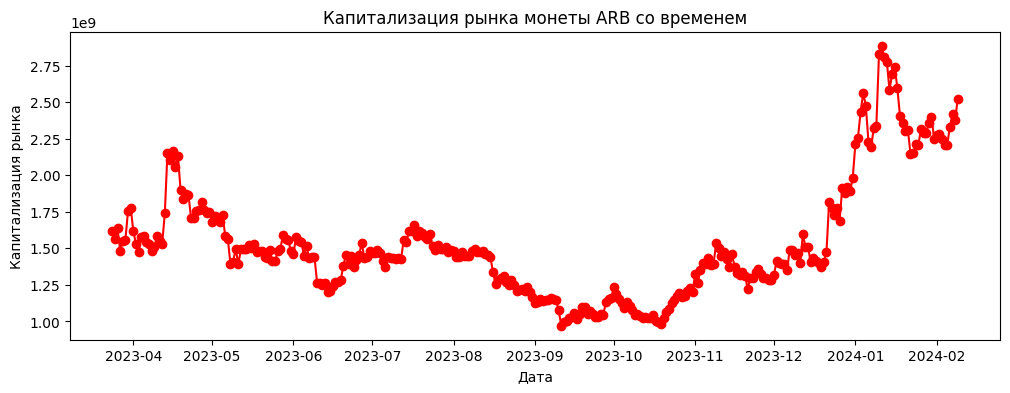

<Figure size 1200x800 with 0 Axes>

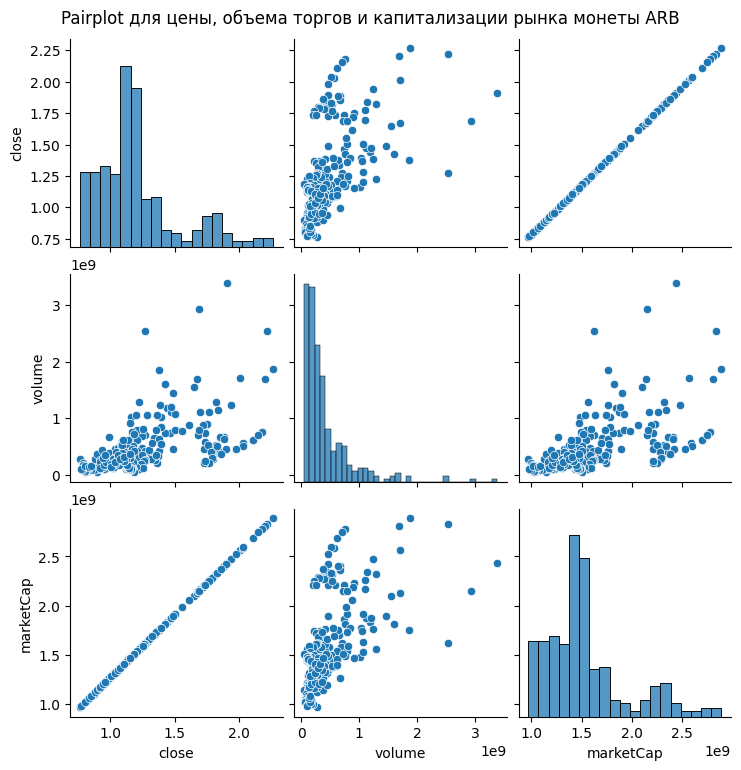

In [5]:
# Создание графика для цен
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['close'], marker='o', linestyle='-', color='b')
plt.title('Изменение цен монеты ARB со временем')
plt.xlabel('Дата')
plt.ylabel('Цена (close)')
plt.show()

# Создание графика для объема торгов
plt.figure(figsize=(12, 4))
plt.bar(df.index, df['volume'], color='g')
plt.title('Объем торгов монеты ARB со временем')
plt.xlabel('Дата')
plt.ylabel('Объем торгов')
plt.show()

# Создание графика для капитализации рынка
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['marketCap'], marker='o', linestyle='-', color='r')
plt.title('Капитализация рынка монеты ARB со временем')
plt.xlabel('Дата')
plt.ylabel('Капитализация рынка')
plt.show()

# Проверка наличия трендов, циклов или паттернов
plt.figure(figsize=(12, 8))
sns.pairplot(df[['close', 'volume', 'marketCap']])
plt.suptitle('Pairplot для цены, объема торгов и капитализации рынка монеты ARB', y=1.02)
plt.show()

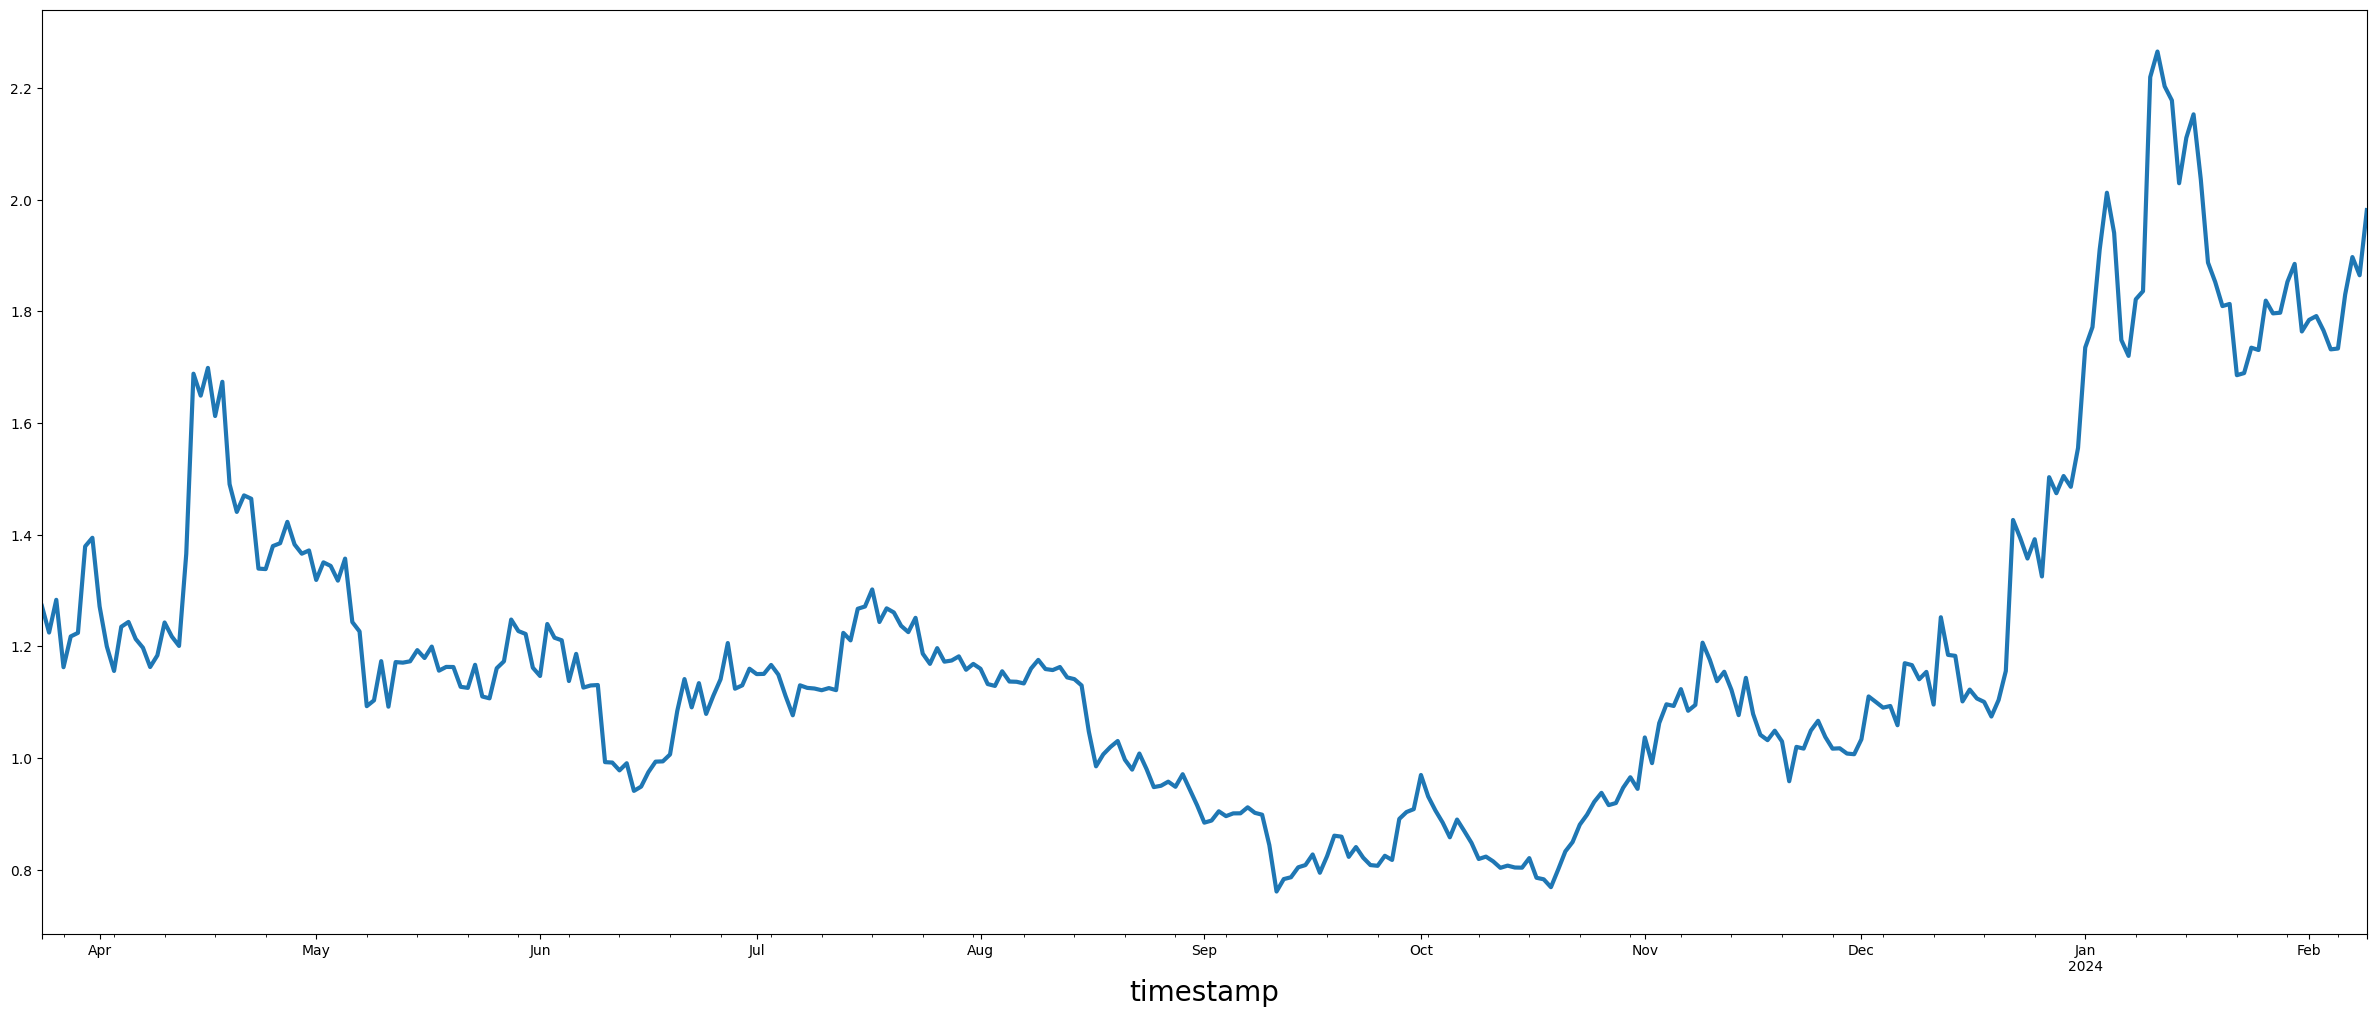

In [6]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df['close'].plot()
plt.show()

#### Вывод: На графиках видно, что общий тренд у нас восходящий, объёмы торгов монеты в среднем растут 

#### Удалим лишние признаки 

In [7]:
df.isna().sum()

name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
dtype: int64

In [8]:
df.drop(columns=['name'], inplace=True)

#### Сделаем корреляционный анализ 

In [9]:


# Вычисляем корреляции
correlation_matrix = df.corr()

# Выводим матрицу корреляций
print(correlation_matrix)

               open      high       low     close    volume  marketCap
open       1.000000  0.988154  0.992117  0.980870  0.548997   0.980870
high       0.988154  1.000000  0.987661  0.993780  0.634613   0.993780
low        0.992117  0.987661  1.000000  0.989351  0.529181   0.989351
close      0.980870  0.993780  0.989351  1.000000  0.602239   1.000000
volume     0.548997  0.634613  0.529181  0.602239  1.000000   0.602239
marketCap  0.980870  0.993780  0.989351  1.000000  0.602239   1.000000


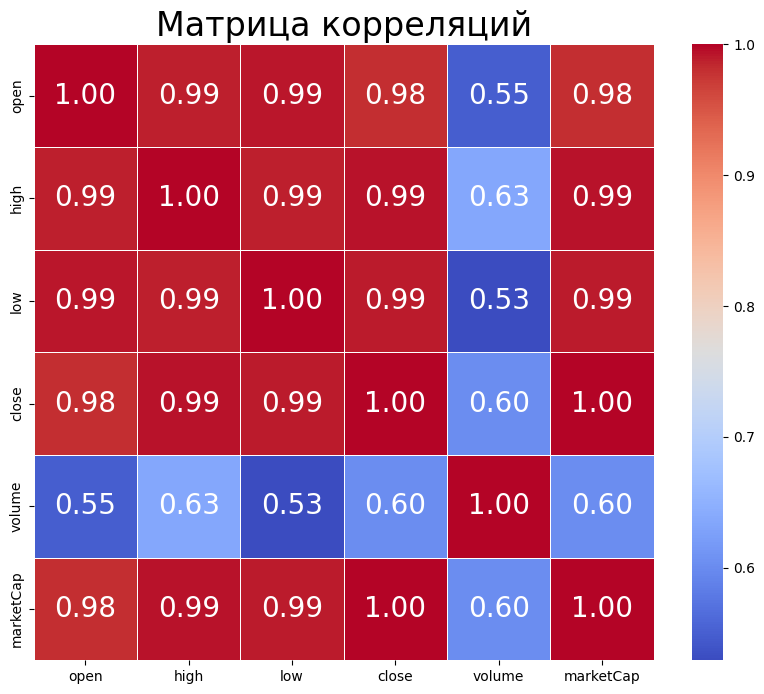

In [10]:
# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляций')
plt.show()

#### Вывод: Тут  мы видим что почти все признаки коррелируют между собой, меньше всего показывают корреляцию объёмы(volume)

#### Разделим данные на обучающую и тестовую выборки, воспользуемся функцией ceil() для округления вверх до ближайшего целого числа

In [11]:

# Первые 75% записей (строк) 
train_df=df.iloc[:ceil(df.shape[0]*0.75)]
# Оставшиеся 25% записей (строк)
test_df=df.iloc[ceil(df.shape[0]*0.75):]

train_df.shape, test_df.shape

((243, 6), (80, 6))

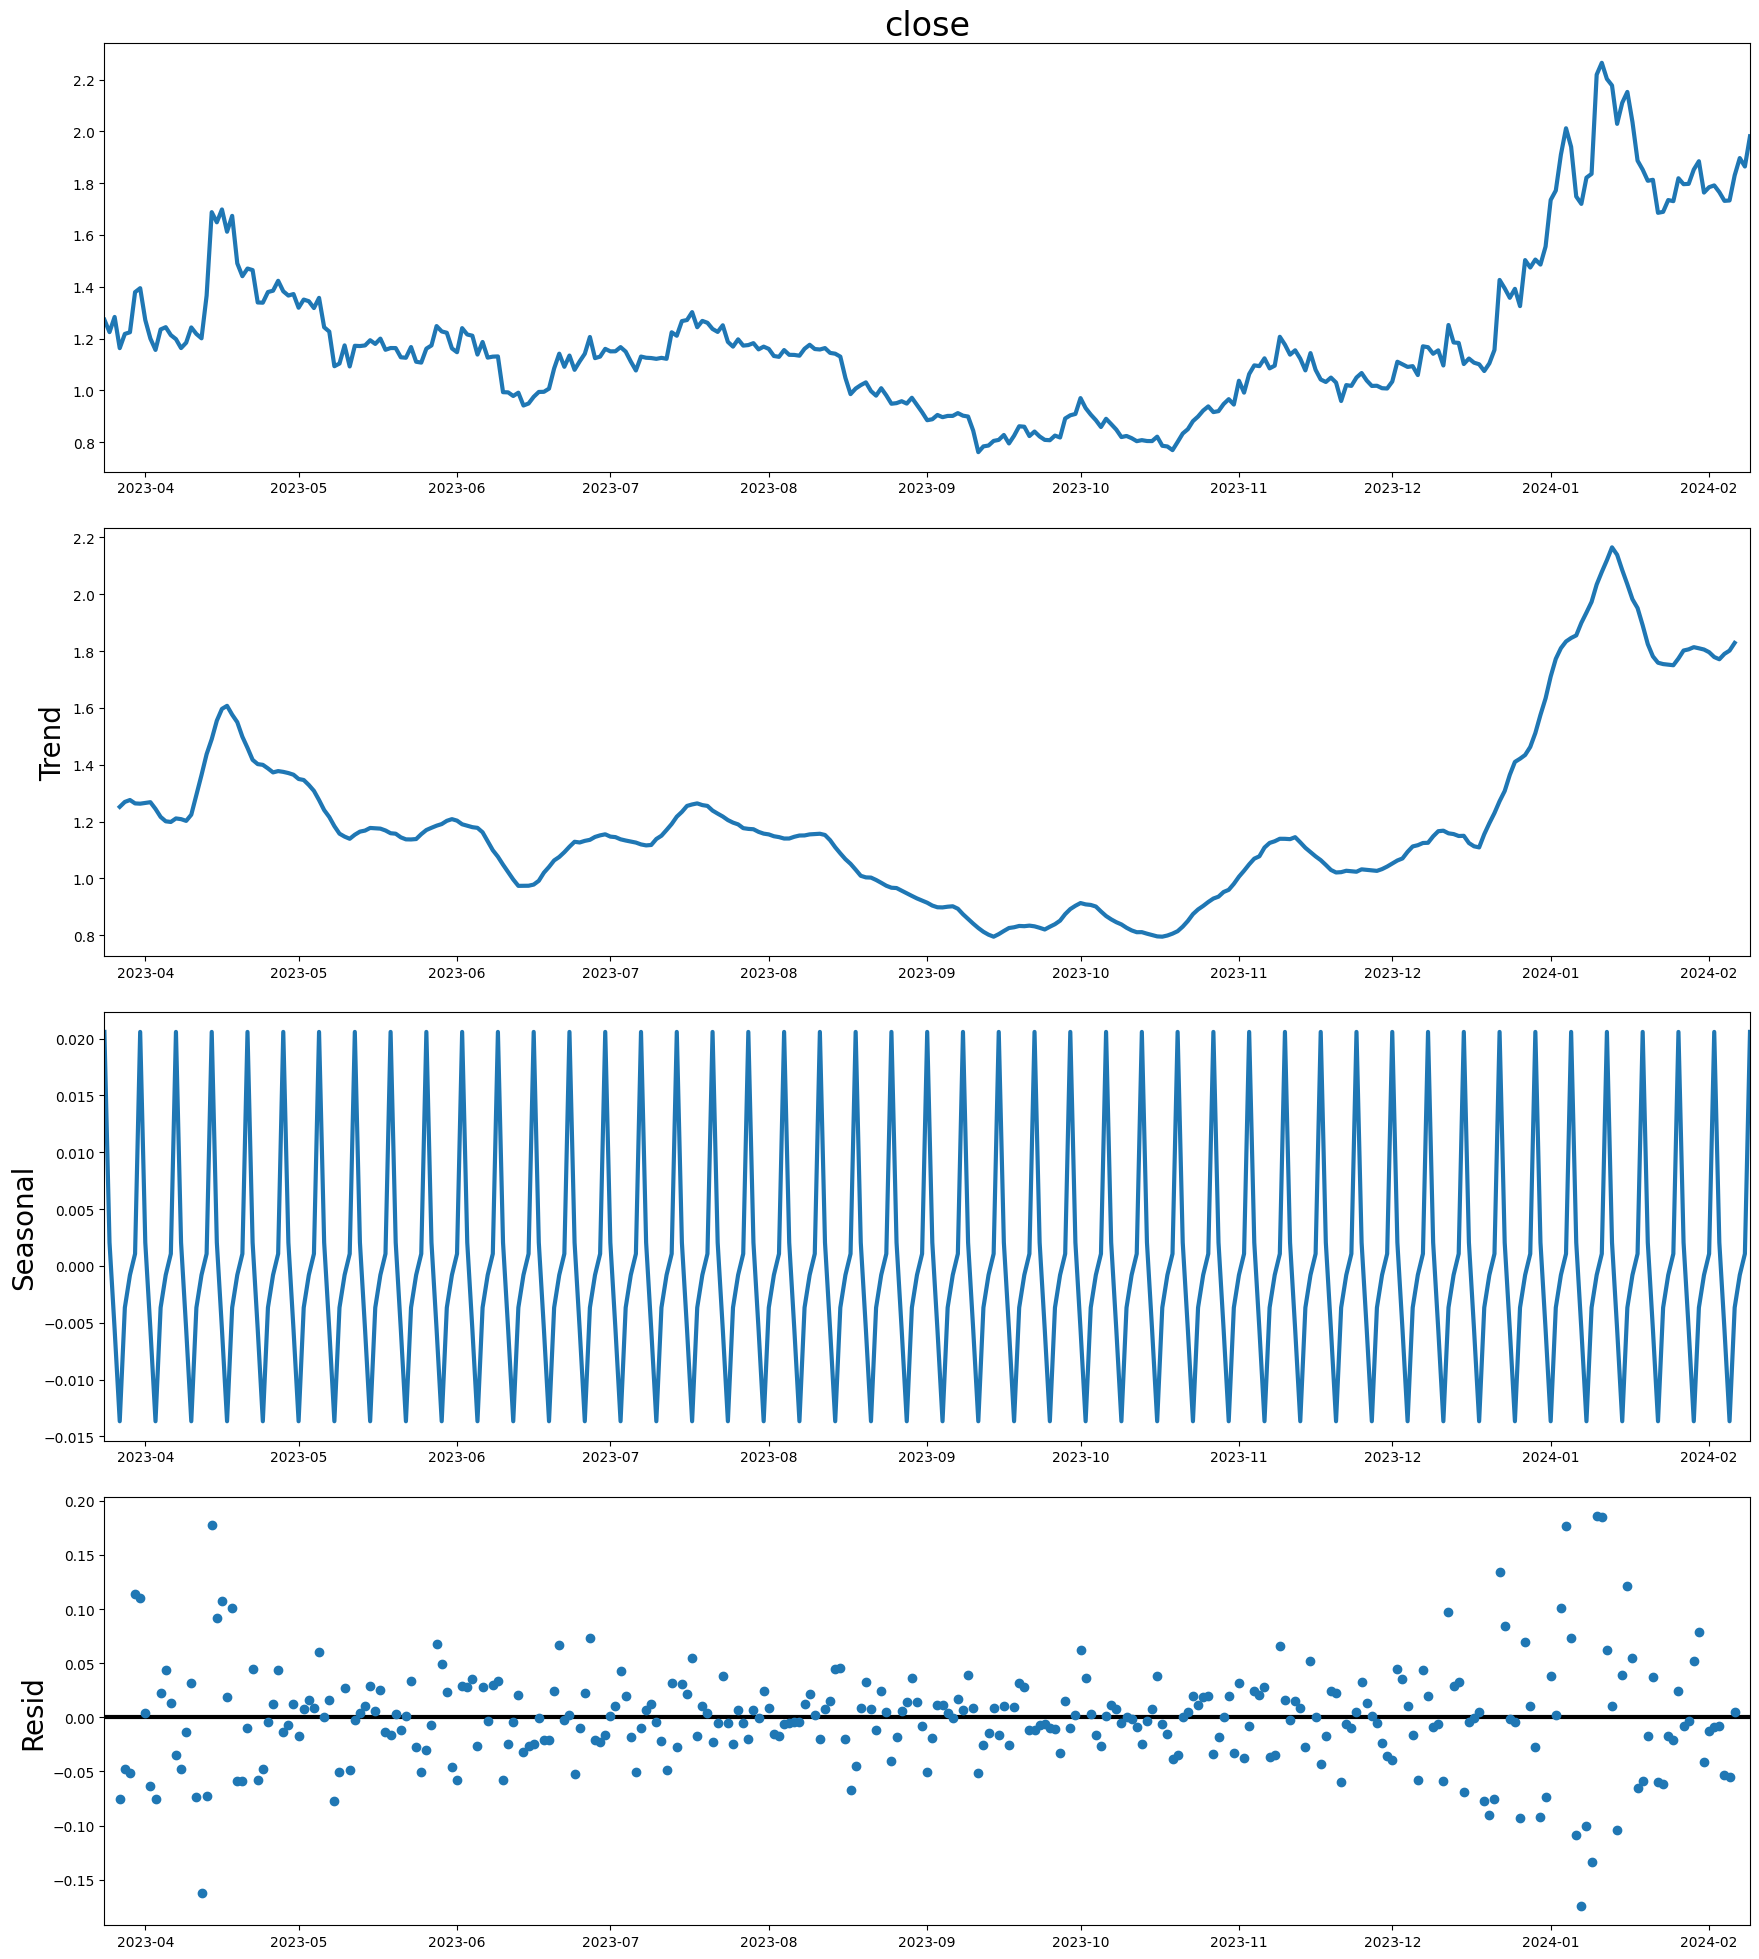

In [12]:
plt.rcParams["figure.figsize"] = 18, 20

# Применение seasonal_decompose
result = seasonal_decompose(df['close'], model='additive')

# Визуализация разложения
result.plot()
plt.show()

#### Вывод: Мы наблюдаем достаточно сильный разброс модели и сезонность, однако также мы видим, что тренд восходящий

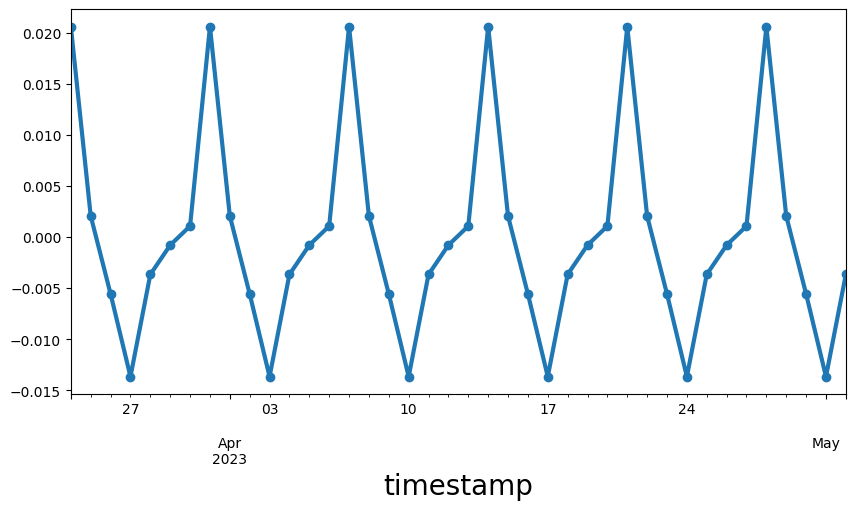

In [13]:
# Посмотрим на первые 40 значений 
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:40].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 7 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на криптовалюту. Мы наблюдаем и собираем данные о ценах каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (7 дней в неделю). Поскольку криптовалютный рынок не закрывается на выходные, как рынок акций.

### Moving Average

In [14]:

def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['close']]
    df_new.head()
    train_df=df_new.iloc[:ceil(shape*0.75)]
    test_df=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('----------ARB PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_df.shape)
    print('Shape of test Set',test_df.shape)
    preds = []
    for i in range(0,test_df.shape[0]):
        a = train_df['close'][len(train_df)-test_df.shape[0]+i:].sum() + sum(preds)
        b = a/(test_df.shape[0])
        preds.append(b)
    rmse = sqrt(mean_squared_error(test_df['close'], preds))
    print(f'RMSE value on test set:{round(rmse,2)}')
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    test_df['Predictions'] = preds
    plt.plot(train_df['close'])
    plt.plot(test_df[['close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('ARB Price',size=20)
    plt.title('ARB Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------
----------ARB PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (243, 1)
Shape of test Set (80, 1)
RMSE value on test set:0.68
-----------------------------------------------------------
-----------------------------------------------------------


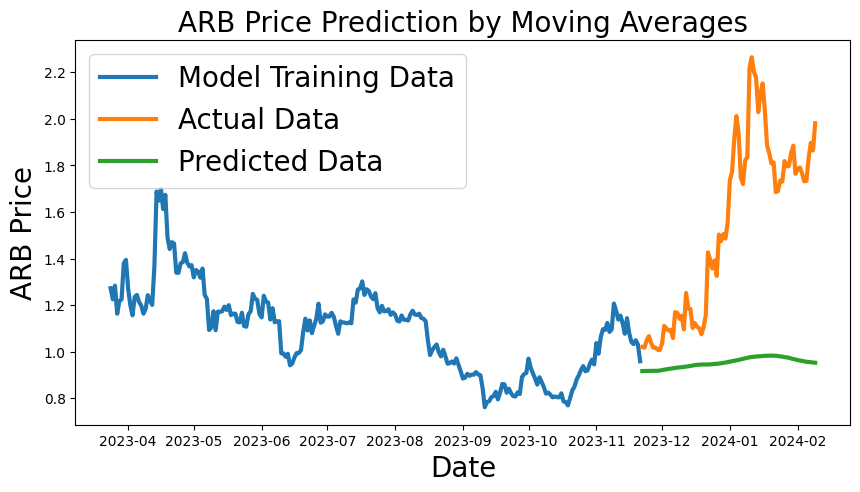

In [15]:
moving_avg_prediction(df)

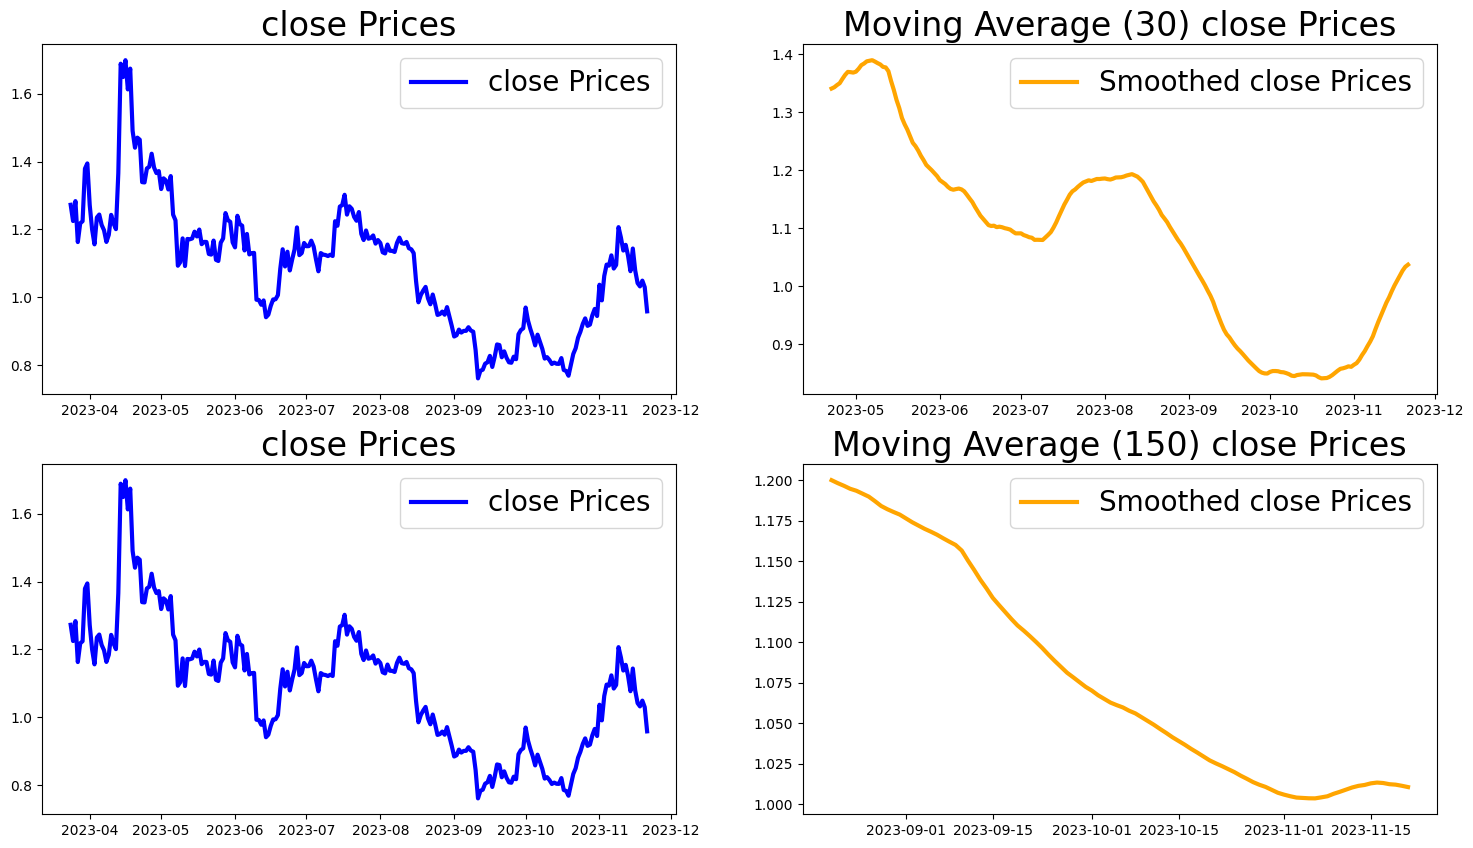

In [16]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.close, color="blue", label="close Prices")
ax[0, 0].set_title("close Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.close.rolling(window=30).mean(),
    color="orange",
    label="Smoothed close Prices",
)

ax[0, 1].set_title("Moving Average (30) close Prices", size=24)
ax[0, 1].legend()


# Окно в полгода (Window = 150)
ax[1, 0].plot(train_df.close, color="blue", label="close Prices")
ax[1, 0].set_title("close Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.close.rolling(window=150).mean(),
    color="orange",
    label="Smoothed close Prices",
)

ax[1, 1].set_title("Moving Average (150) close Prices", size=24)
ax[1, 1].legend()

plt.show()

#### Вывод: Мы видим что Moving average(MA) очень плохо подстраивается под данные 

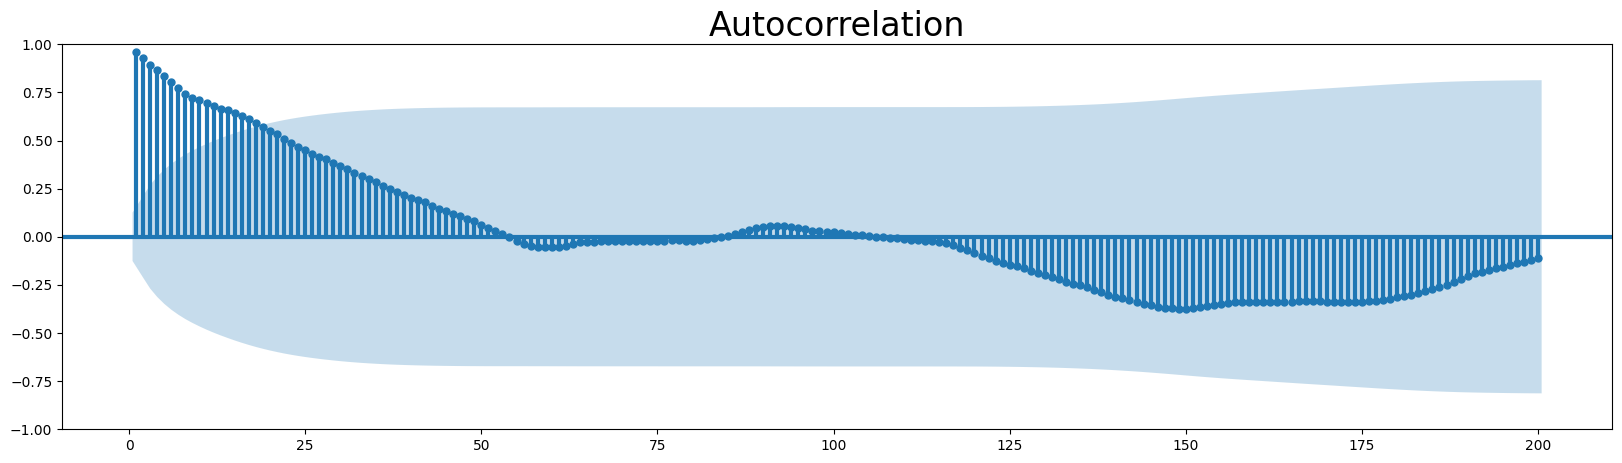

In [17]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.close, lags=200, zero=False)
plt.show()

#### Мы видим что данные имеют Периодические паттерны. Сначала идёт снижение, затем постепенный рост. Это указывает на наличие цикличности в данных

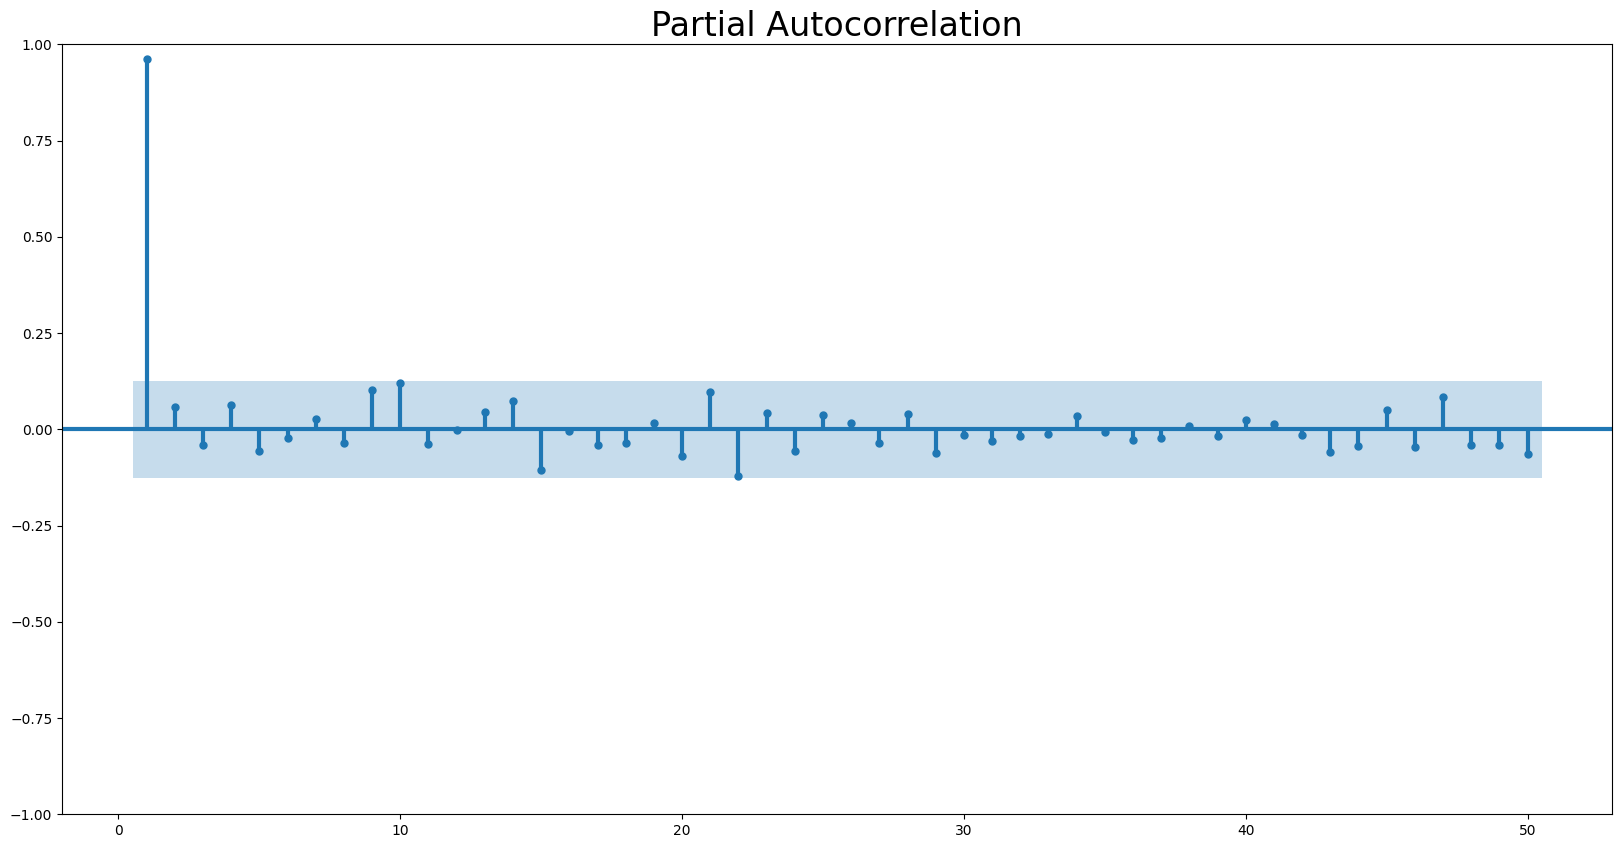

In [18]:

plt.rcParams["figure.figsize"] = 20, 10
sgt.plot_pacf(train_df.close, lags=50, method="ywm", zero=False)
plt.show()

#### Мы видим что за пределы 95% доверительного интервала выходит сильнее всего 1 лаг. Значит P = 1

In [19]:
# Проверяем даты на пропущенные значения 
df.asfreq(freq='AS').isna().sum()

open         0
high         0
low          0
close        0
volume       0
marketCap    0
dtype: int64

In [20]:
df

,open,high,low,close,volume,marketCap
timestamp,,,,,,
2023-03-24 00:00:00+00:00,1.325396,1.555872,1.186060,1.272492,2.537710e+09,1.622427e+09
2023-03-25 00:00:00+00:00,1.272393,1.307232,1.192970,1.224705,1.294894e+09,1.561498e+09
2023-03-26 00:00:00+00:00,1.224117,1.341853,1.208092,1.283315,1.059588e+09,1.636227e+09
2023-03-27 00:00:00+00:00,1.282521,1.320275,1.124495,1.162705,1.014241e+09,1.482449e+09
2023-03-28 00:00:00+00:00,1.162855,1.220483,1.120494,1.217757,6.966363e+08,1.552640e+09
...,...,...,...,...,...,...
2024-02-05 00:00:00+00:00,1.731823,1.784624,1.705823,1.733229,2.487814e+08,2.209867e+09
2024-02-06 00:00:00+00:00,1.733197,1.871273,1.728937,1.830087,5.049751e+08,2.333361e+09
2024-02-07 00:00:00+00:00,1.830078,1.929141,1.812190,1.897009,4.586080e+08,2.418686e+09


In [21]:
# Проводим интерполяцию
df.interpolate(method='linear', inplace=True)

#### Проверка рядов на стационарность 

In [22]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df['close'])

adf:  -2.1262087798382114
p-value:  0.2341073277695273
Critical values:  {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}
есть единичные корни, ряд не стационарен


#### Дифференцирование ряда

In [23]:
# Если не стационарный ряд 
otg1diff = df.diff(periods=1).dropna()
otg1dif_new = otg1diff.diff(periods=1).dropna()


In [24]:
stat_test(otg1dif_new['close'])

adf:  -9.317890558285177
p-value:  1.0075599533733078e-15
Critical values:  {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}
единичных корней нет, ряд стационарен


#### Построим ещё раз коррелограммы на стационарном ряде

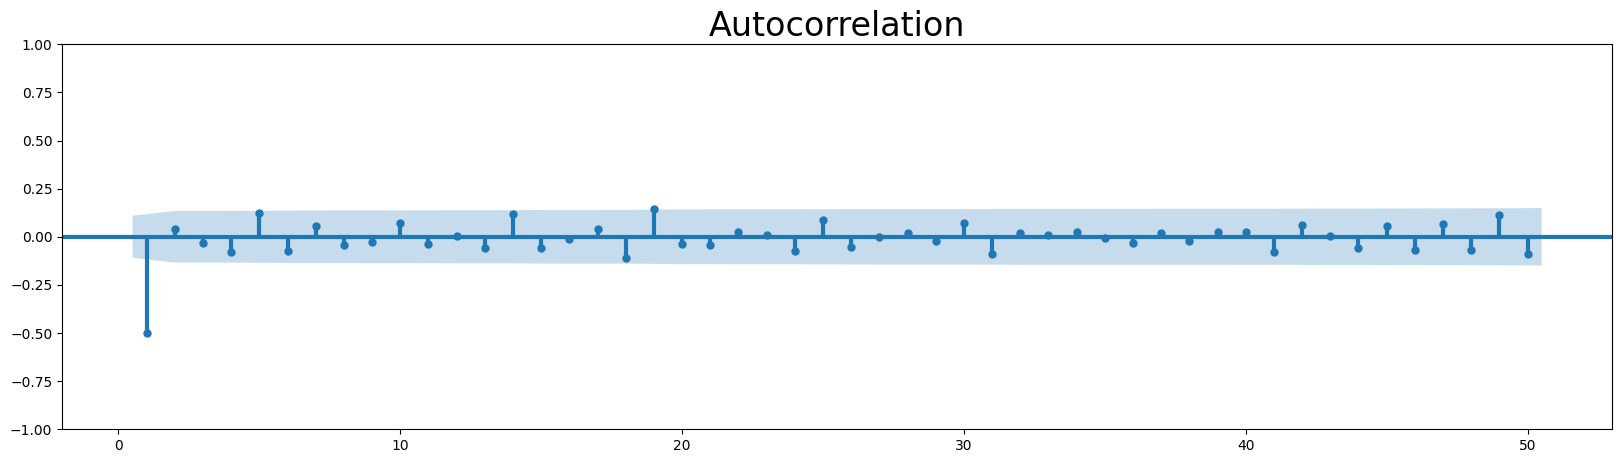

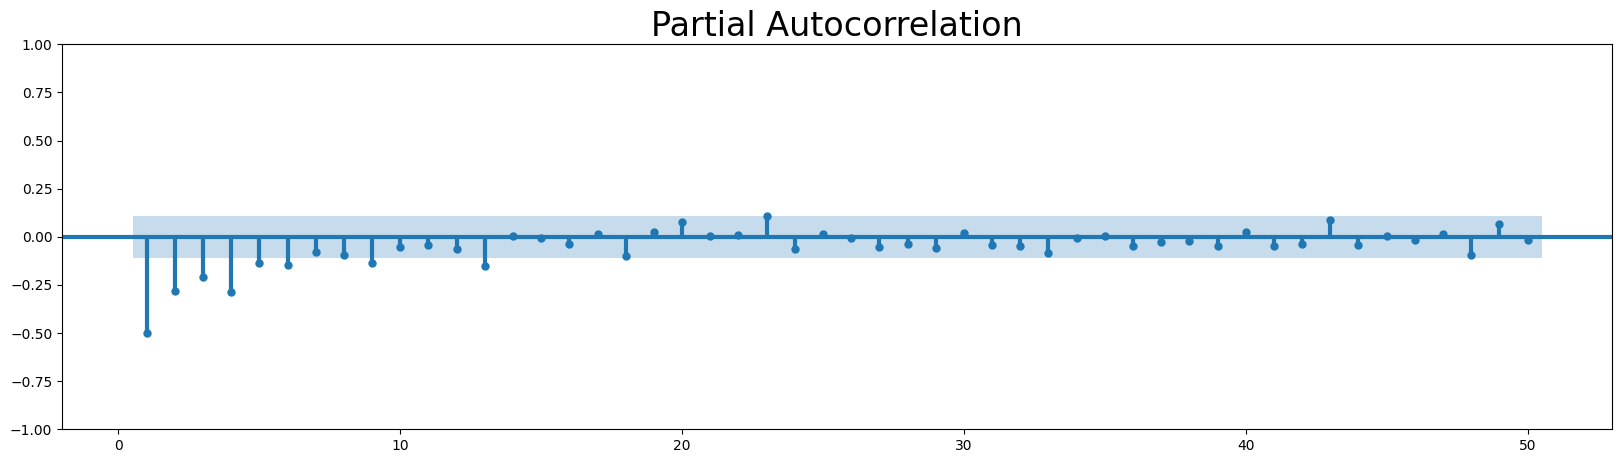

In [25]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(otg1dif_new['close'], lags=50, zero=False)
plt.show() 
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(otg1dif_new['close'], lags=50, method="ywm", zero=False)
plt.show()

#### Вывод: На графике PACF мы уже можем видеть плавный восходящий тренд в самом начале, а потом опять хаотичные движения

#### Выполним разбиение walk forward validation

In [26]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(df['close']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 302 TEST size: 7
TRAIN size: 309 TEST size: 7
TRAIN size: 316 TEST size: 7


In [27]:
tscv = TimeSeriesSplit(max_train_size=df['close'].count() -7)

train_test_groups = tscv.split(df['close']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 58 TEST size: 53
TRAIN size: 111 TEST size: 53
TRAIN size: 164 TEST size: 53
TRAIN size: 217 TEST size: 53
TRAIN size: 270 TEST size: 53


#### Вывод: Получили множественное разбиение, так как объём обучающих выборок различен

### ARIMA, SARIMAX, AUTO ARIMA
#### Начнем построение модели ARIMA со следующими параметрами:

* p = 1
* d = 1
* q = 1
#### Если рассматривать сезонную модель (SARIMAX), то в модель можно добавить следующие параметры.

* m = 5 
* P = 1
* D = 1
* Q = 1

### ARIMA

In [28]:
arima_model = ARIMA(train_df['close'].dropna(), order=(3, 1, 3), seasonal_order=(0, 1, 1, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                  243
Model:             ARIMA(3, 1, 3)x(0, 1, [1], 5)   Log Likelihood                 367.295
Date:                           Sun, 11 Feb 2024   AIC                           -718.590
Time:                                   01:09:25   BIC                           -690.846
Sample:                               03-24-2023   HQIC                          -707.407
                                    - 11-21-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0800      2.733     -0.029      0.977      -5.437       5.277
ar.L2         -0.0409      2.045     -0.020      0.984      -4.050       3.968
ar.L3         -0.2415      1.474     -0.164      0.870      -3.130       2.647
ma.L1          0.0265      2.732      0.010      0.992      -5.327       5.380
ma.L2          0.0565      1.978      0.029      0.977      -3.820       3.933
ma.L3          0.1999      1.406      0.142      0.887      -2.557       2.956
ma.S.L5       -0.9534      0.058    -16.366      0.000      -1.068      -0.839
sigma2         0.0025      0.000     12.416      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               339.96
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Auto Arima

----------------------------------------------------------
-----------ARB PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (243, 6)
Shape of test Set (80, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-567.936, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-622.628, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-566.042, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-651.924, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-652.943, Time=0.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-624.545, Time=0.21 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(1,1,1

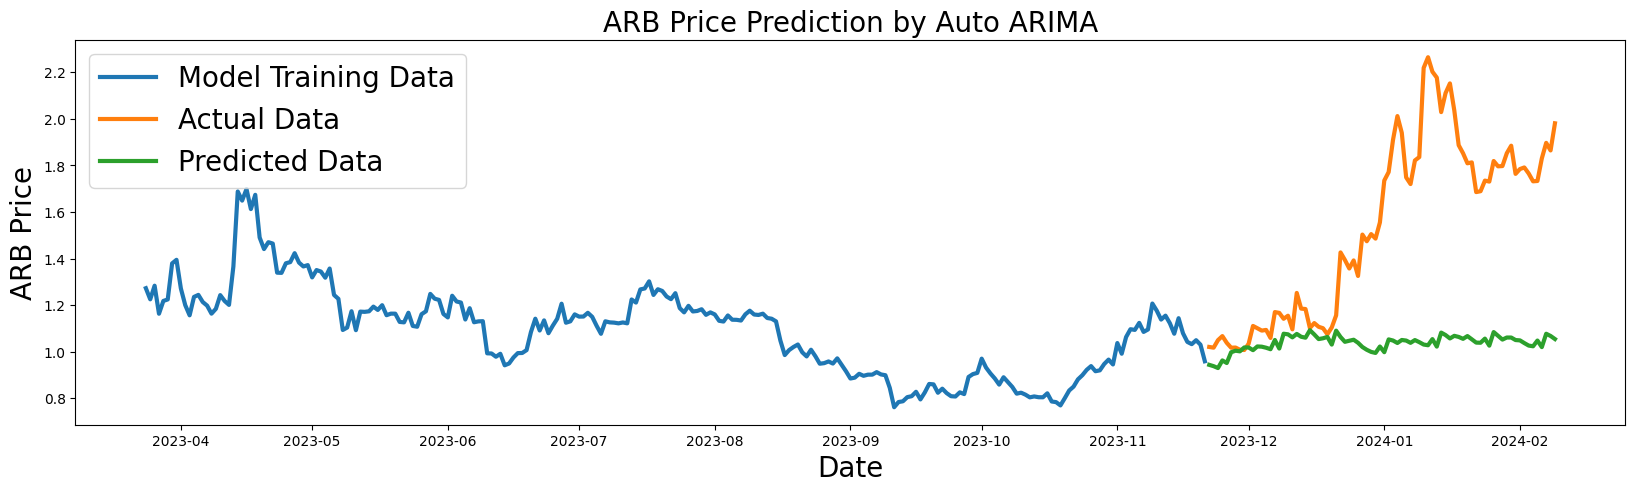

In [29]:
def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_df=data[:ceil(shape*0.75)]
    test_df=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------ARB PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_df.shape)
    print('Shape of test Set',test_df.shape)
    training = train_df['close']
    testing = test_df['close']
    model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = test_df.index,columns=['Prediction'])
    rmse = sqrt(mean_squared_error(test_df['close'], forecast['Prediction']))
    print(f'RMSE value on test set:{round(rmse,2)}')
    print('-----------------------------------------------------------')
    plt.plot(train_df['close'])
    plt.plot(test_df['close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('ARB Price',size=20)
    plt.title('ARB Price Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    
auto_arima_prediction(df)

### SARIMAX

In [30]:
seas_model = SARIMAX(
    train_df['close'].dropna(), order=(0, 2, 2), seasonal_order=(0, 2, 2, 12)
)


seas_model_fit = seas_model.fit()
seas_model_fit.summary()

C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                  243
Model:             SARIMAX(0, 2, 2)x(0, 2, 2, 12)   Log Likelihood                 279.041
Date:                            Sun, 11 Feb 2024   AIC                           -548.081
Time:                                    01:09:48   BIC                           -531.182
Sample:                                03-24-2023   HQIC                          -541.255
                                     - 11-21-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0077      0.079    -12.837      0.000      -1.162      -0.854
ma.L2          0.0399      0.059      0.679      0.497      -0.075       0.155
ma.S.L12      -1.9497      3.918     -0.498      0.619      -9.629       5.729
ma.S.L24       0.9962      4.015      0.248      0.804      -6.874       8.866
sigma2         0.0029      0.011      0.250      0.802      -0.020       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               108.25
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

-----------------------------------------------------------
----------ARB PRICE PREDICTION BY SARIMAX MODEL-------------
-----------------------------------------------------------
Shape of Training Set (243, 1)
Shape of test Set (80, 1)


C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\bubul\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE value on test set:0.55
-----------------------------------------------------------
-----------------------------------------------------------


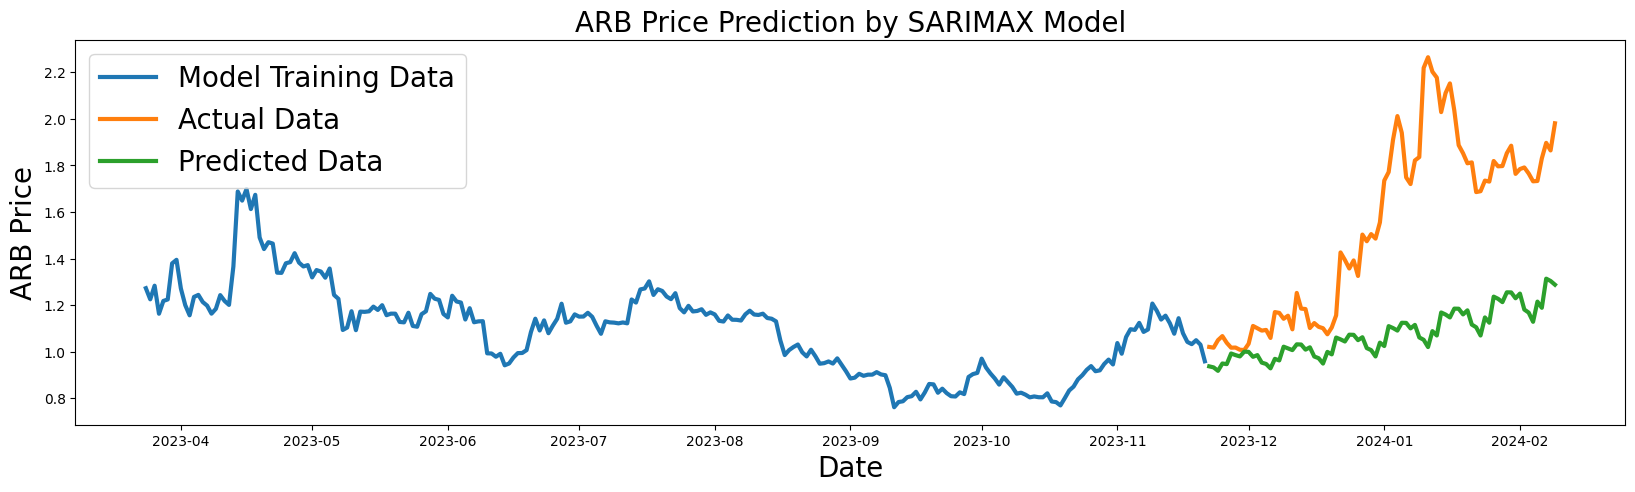

In [31]:
def sarimax_prediction(df):
    shape = df.shape[0]
    df_new = df[['close']]
    df_new.head()
    train_df = df_new.iloc[:ceil(shape * 0.75)]
    test_df = df_new.iloc[ceil(shape * 0.75):]

    print('-----------------------------------------------------------')
    print('----------ARB PRICE PREDICTION BY SARIMAX MODEL-------------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set', train_df.shape)
    print('Shape of test Set', test_df.shape)

    order = (0, 2, 2)  
    seasonal_order = (0, 2, 2, 12)  
    model = SARIMAX(train_df['close'], order=order, seasonal_order=seasonal_order)
    sarimax_model = model.fit(disp=False)

    # Forecast
    preds = sarimax_model.get_forecast(steps=test_df.shape[0])
    preds_mean = preds.predicted_mean.values

    rmse = sqrt(mean_squared_error(test_df['close'], preds_mean))
    print(f'RMSE value on test set:{round(rmse,2)}')
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    # Add Predictions to DataFrame
    test_df['Predictions'] = preds_mean

    # Plotting
    plt.plot(train_df['close'])
    plt.plot(test_df[['close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('ARB Price', size=20)
    plt.title('ARB Price Prediction by SARIMAX Model', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()


sarimax_prediction(df)

#### Вывод: Со стандартными значениями модель SARIMAX показывает лучшие результаты в сравнении с ARIMA. 
#### При выставлении одинаковых order=(3, 1, 3), seasonal_order=(0, 1, 1, 5). Модель SARIMAX & ARIMA показывают почти схожие результаты. Однако мы подобрали параметры так что модель SARIMAX показывает в конечном результате RMSE ниже чем AUTO ARIMA 

#### 95% Доверительный интервал

In [32]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['close'] = df['close']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower close"]
pred_df.at[test_df.index, "model_preds_upper"] =  forecast_df["upper close"] 

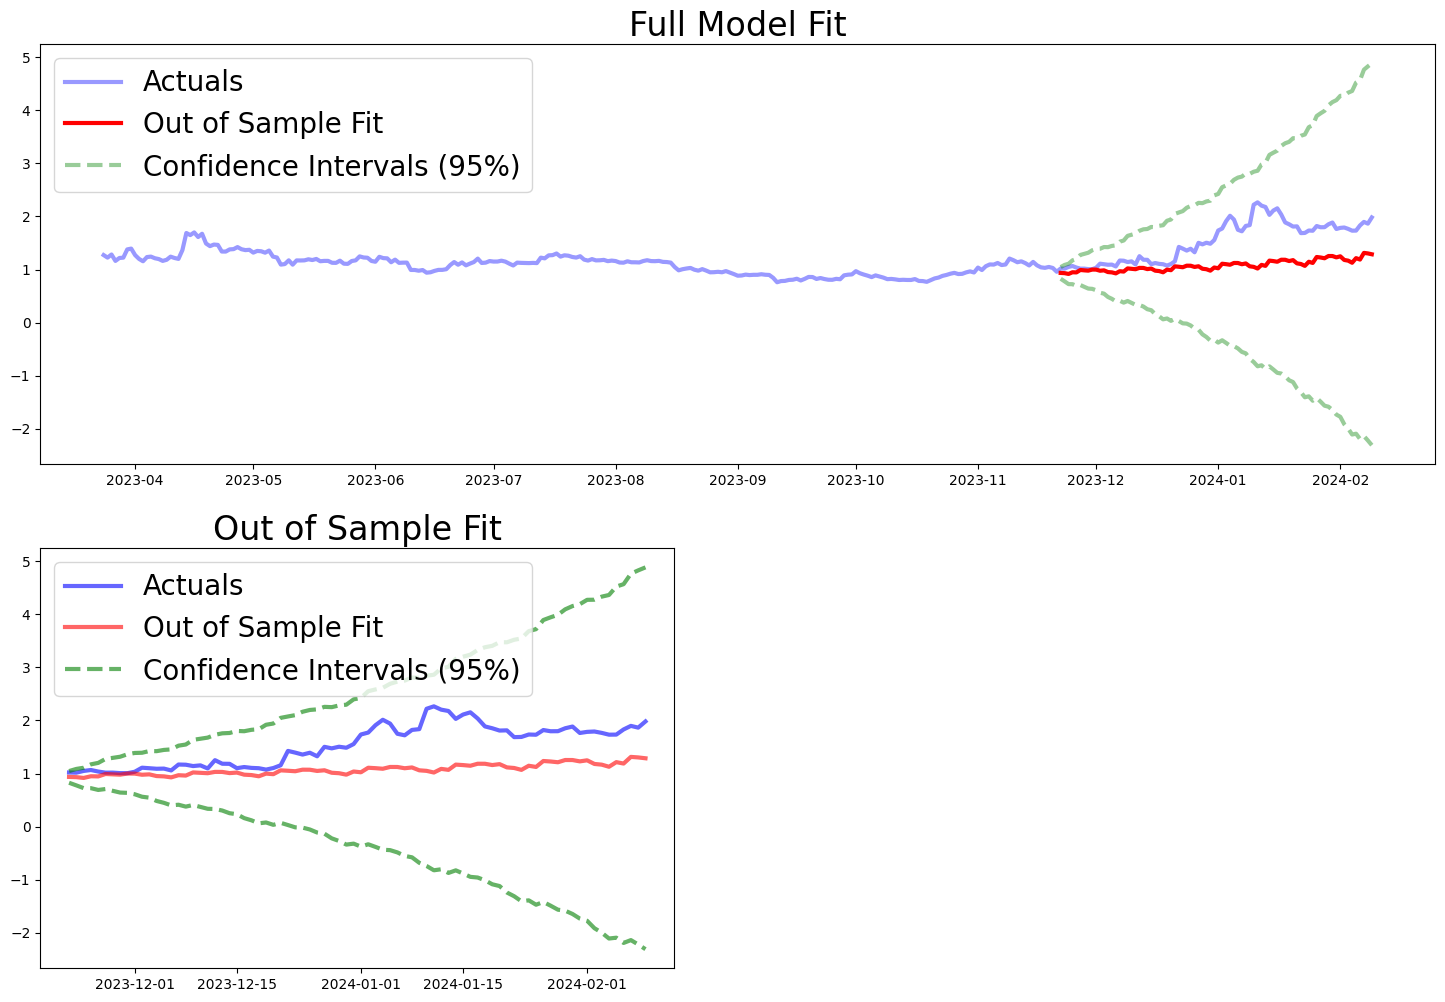

In [33]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['close'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['close'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

#### Волатильность

In [34]:
df["close_vol"] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
df["close_vol"] = df['close'].pct_change(1).mul(100).abs()
df["close_vol"].head()

timestamp
2023-03-24 00:00:00+00:00         NaN
2023-03-25 00:00:00+00:00    3.755390
2023-03-26 00:00:00+00:00    4.785701
2023-03-27 00:00:00+00:00    9.398329
2023-03-28 00:00:00+00:00    4.734820
Name: close_vol, dtype: float64

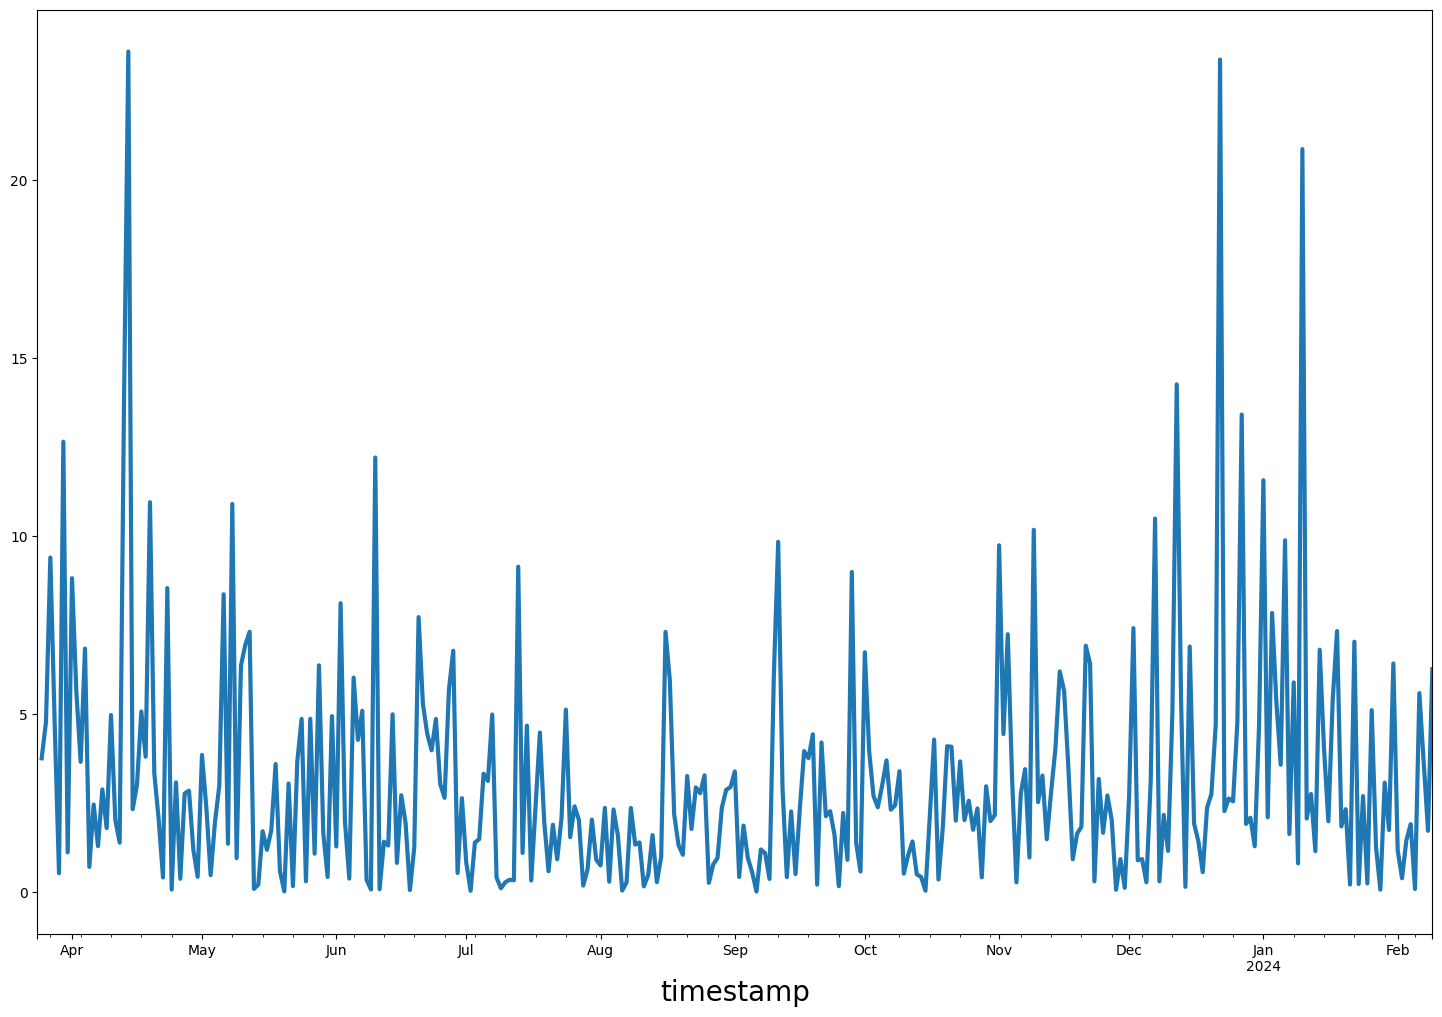

In [35]:
df['close_vol'].plot()
plt.show()

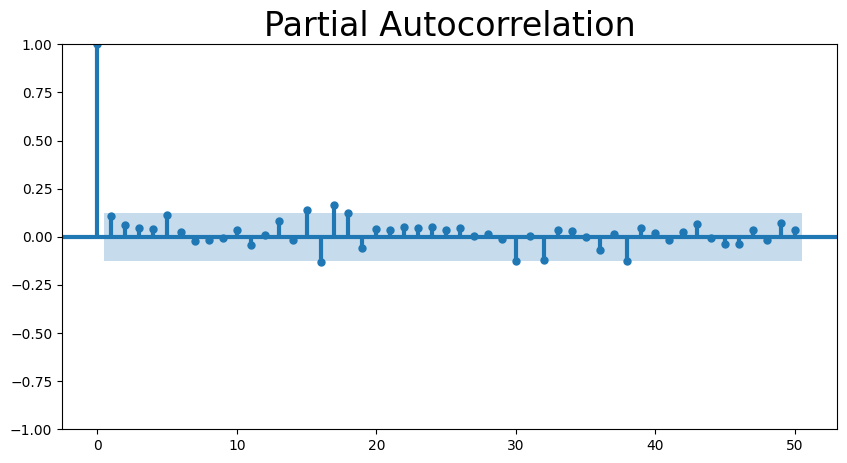

In [36]:
plt.rcParams["figure.figsize"] = 10, 5


train_df=df.iloc[:ceil(df.shape[0]*0.75)]

test_df=df.iloc[ceil(df.shape[0]*0.75):]

sgt.plot_pacf(train_df['close_vol'][1:], lags=50, method="ywm")
plt.show()

In [37]:
adfuller(train_df['close_vol'][1:])

(-13.835054507909577,
 7.469793495324043e-26,
 0,
 241,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991},
 1119.3139780761812)

#### Построим модель PROPHET

In [38]:
# Форматирование индекса в формат года/месяца/дня для нашей модели PROPHET
df.index = df.index.strftime('%Y-%m-%d')
df.head()

,open,high,low,close,volume,marketCap,close_vol
timestamp,,,,,,,
2023-03-24,1.325396,1.555872,1.186060,1.272492,2.537710e+09,1.622427e+09,NaN
2023-03-25,1.272393,1.307232,1.192970,1.224705,1.294894e+09,1.561498e+09,3.755390
2023-03-26,1.224117,1.341853,1.208092,1.283315,1.059588e+09,1.636227e+09,4.785701
2023-03-27,1.282521,1.320275,1.124495,1.162705,1.014241e+09,1.482449e+09,9.398329
2023-03-28,1.162855,1.220483,1.120494,1.217757,6.966363e+08,1.552640e+09,4.734820


In [39]:
# Снова разобъём наши данные 

# Первые 75% записей (строк) 
train_df=df.iloc[:ceil(df.shape[0]*0.75)]
# Оставшиеся 25% записей (строк)
test_df=df.iloc[ceil(df.shape[0]*0.75):]

train_df.shape, test_df.shape

((243, 7), (80, 7))

In [40]:
# Создание модели
model = Prophet()

# Обучение модели
model.fit(train_df.reset_index().rename(columns={'timestamp': 'ds', 'close': 'y'}))

# Делаем прогноз на всей тестовой выборке
future = model.make_future_dataframe(periods=len(test_df))

# Прогноз
forecast = model.predict(future)

# Вывод результатов
print(forecast[['ds', 'yhat']].tail())

01:09:57 - cmdstanpy - INFO - Chain [1] start processing
01:09:57 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat
318 2024-02-05  1.215307
319 2024-02-06  1.226860
320 2024-02-07  1.224564
321 2024-02-08  1.228720
322 2024-02-09  1.252387


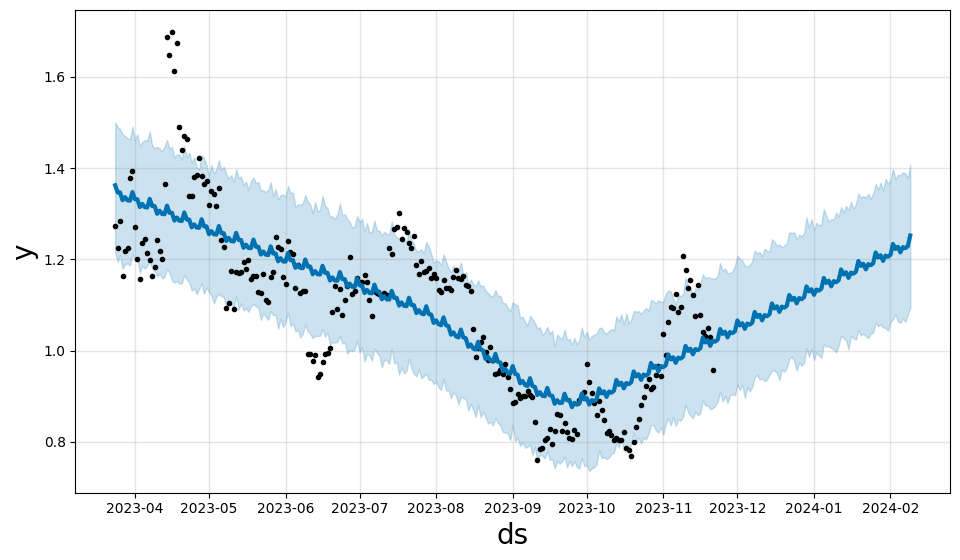

In [41]:
fig = model.plot(forecast)

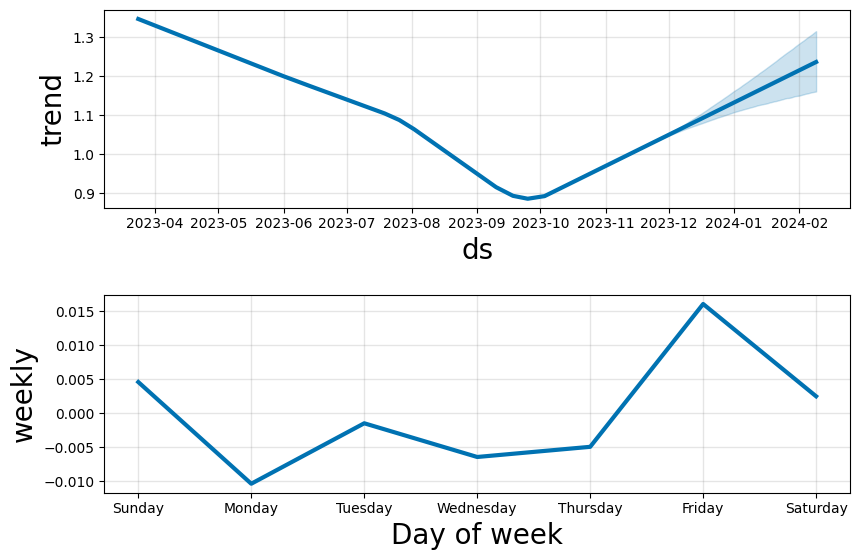

In [42]:
fig = model.plot_components(forecast)

In [43]:

# Извлечение фактических значений из тестовой выборки
y_true = test_df['close'].values
# Извлечение предсказанных значений из прогноза
forecast_test = forecast['yhat'][ceil(forecast.shape[0]*0.75):]
# вычисление RMSE 
rmse=sqrt(mean_squared_error(y_true, forecast_test))

print(f'RMSE value on test_df:{round(rmse, 2)}')

RMSE value on test_df:0.52


#### Вывод:  модель ошибается на 0.52 что довольно много  

### Long Short Term Memory (LSTM)

-----------------------------------------------------------------------------
-----------ARB PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (243, 1)
Shape of test Set (80, 1)



203/203 - 6s - loss: 0.0044 - 6s/epoch - 27ms/step
3/3 [==============================] - 1s 10ms/step
RMSE value on test set: 0.20760686585249738
-----------------------------------------------------------
-----------------------------------------------------------


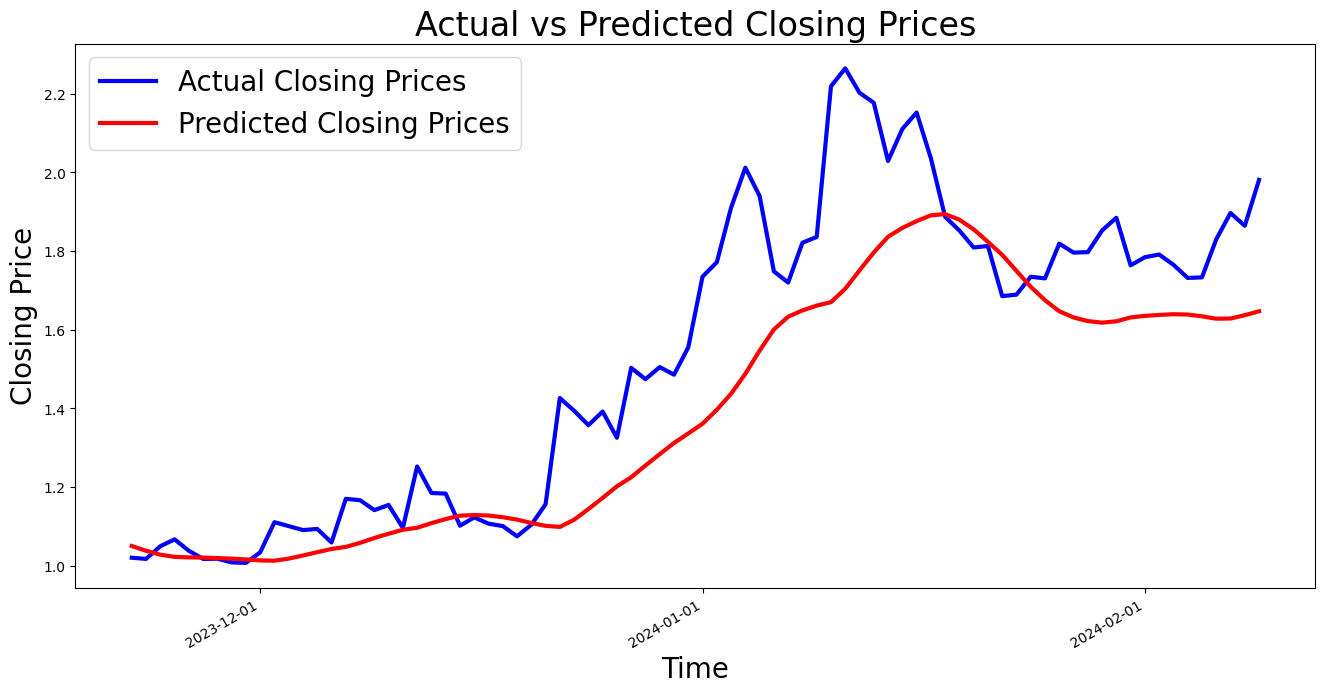

In [44]:

def lstm_prediction(df):
    shape = df.shape[0]
    df_new = df[['close']]
    df_new.head()
    dataset = df_new.values
    train = df_new[:ceil(shape * 0.75)]
    test = df_new[ceil(shape * 0.75):]

    print('-----------------------------------------------------------------------------')
    print('-----------ARB PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set', train.shape)
    print('Shape of test Set', test.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_df[i - 40:i, 0])
        y_train.append(scaled_df[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    inputs = df_new[len(df_new) - len(test) - 40:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i - 40:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    rms = sqrt(mean_squared_error(test['close'], closing_price))
    print('RMSE value on test set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    test['Predictions'] = closing_price
    
# Преобразуем индекс в datetime для получения более точных меток по оси x
    test.index = pd.to_datetime(test.index)

    plt.figure(figsize=(16,8))
    plt.plot(test.index, test['close'], label='Actual Closing Prices', color='blue')

# Построение прогнозируемых цен закрытия
    plt.plot(test.index, test['Predictions'], label='Predicted Closing Prices', color='red')

    plt.title('Actual vs Predicted Closing Prices')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()

# Форматирование оси x для более четкого отображения дат
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    plt.show()

lstm_prediction(df)

#### Вывод: Модель неплохо себя показала, ошибка RMSE оказалась ниже по сравнению с предыдущими моделями

### Построим модель AutmoML framework FEDOT

#### Установим последнюю версию !pip install fedot==0.7.1 

In [45]:
!pip install fedot==0.7.1 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:

from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.pipelines.pipeline_builder import PipelineBuilder


2024-02-11 01:10:20,656 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, ridge, lagged, glm]}
ridge - {}
ridge - {}
lagged - {'window_size': 10}
glm - {'family': 'gaussian', 'link': 'identity'}
2024-02-11 01:10:20,659 - MemoryAnalytics - Memory consumption for finish in main session: current 0.6 MiB, max: 1.3 MiB
RMSE: 0.63


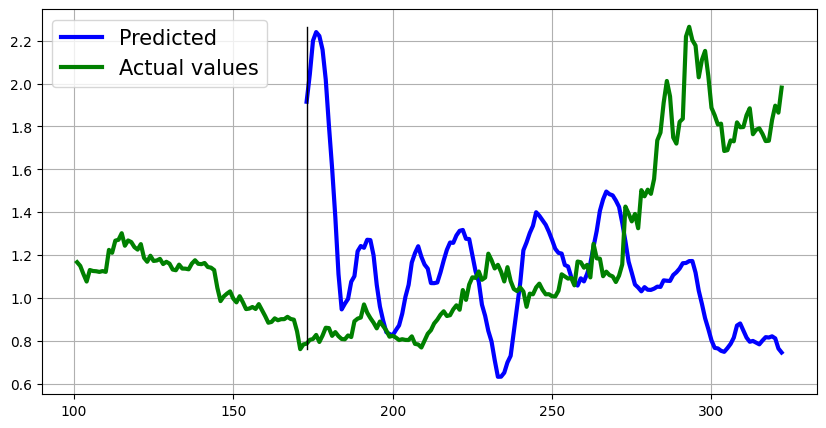

In [47]:

# Создадим свой пайплайн
pipeline = PipelineBuilder() \
    .add_sequence('lagged', 'ridge', branch_idx=0) \
    .add_sequence('glm', branch_idx=1).join_branches('ridge').build()

# возьмём forecast_length = 150
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=150))

# load data from csv
train_input = InputData.from_csv_time_series(task=task,
                                             file_path='data/ARB_All_graph_coinmarketcap_update.csv',
                                             delimiter=';',
                                             target_column='close')

# Разобьём данные 
train_data, test_data = train_test_data_setup(train_input)

# создадим  модель   на 3 фолдах
model = Fedot(problem='ts_forecasting', task_params=task.task_params, cv_folds=3)

# обучим модель
model.fit(train_data, predefined_model=pipeline)

# Сделаем прогноз 
forecast = model.forecast(test_data)

# Выведем RMSE
rmse_value = model.get_metrics(metric_names=['rmse'], target=test_data.target)['rmse']

print(f"RMSE: {rmse_value:.2f}")

model.plot_prediction()

#### Вывод: мы видим что модель тоже показывает не очень хорошие результаты, Predicted пошло вообще не в ту сторону 

### Общий вывод: Лучший результат среди всех рассмотренных нами моделей показала модель LSTM. Также стоит отметить что на рынках существует очень много психологических факторов, сезонности, а также происходят постоянно различные манипуляции с помощью маркет-мейкеров, предсказать это почти нереально,  поэтому нельзя опираться только лишь на данные модели 